How many citations (incoming and outgoing), as in OpenCitations, are the research objects involved in?

In [50]:
import requests, pandas as pd, time, logging
from urllib.parse import quote_plus
from tqdm.auto import tqdm

df  = pd.read_csv("C:/Users/annan/Downloads/mashup_IRIS_subset.csv", low_memory=False)   
list_doi = df["doi"].dropna().tolist() 

In [ ]:
BASE = "https://opencitations.net/index/api/v2"
HEADERS = {"User-Agent": "CitationsBot/0.1 (mailto:you@example.com)"}

logging.basicConfig(
    filename="citations_errors.log",
    level=logging.INFO,
    format="%(asctime)s %(levelname)s: %(message)s"
)

session = requests.Session()
session.headers.update(HEADERS)


In [ ]:
def fetch(endpoint, *, max_retries=3, pause=7):
    """Return JSON list or raise after exhausting retries."""
    for attempt in range(max_retries):
        try:
            r = session.get(endpoint, timeout=15)
            if r.status_code == 429:
                # rate-limit → wait a bit longer
                time.sleep(pause * 2)
                continue
            r.raise_for_status()
            return r.json()
        except (requests.RequestException, ValueError) as e:
            # ValueError covers JSON decode errors
            logging.info("attempt %d failed for %s: %s", attempt + 1, endpoint, e)
            time.sleep(pause)
    # All retries failed → raise to signal a fatal fail for this DOI
    raise RuntimeError(f"❌ all retries failed for {endpoint}")


In [ ]:
def get_objects(kind, doi):
    """Wrap fetch() and return [], not raise, on total failure."""
    url = f"{BASE}/{kind}/doi:{quote_plus(doi)}"
    try:
        return fetch(url)
    except Exception as e:
        logging.error("%s – giving up: %s", doi, e)
        return None      # keep a sentinel to flag the miss in the table

In [ ]:
rows = []
for doi in tqdm(list_doi):
    outgoing = get_objects("references", doi)
    ingoing  = get_objects("citations",  doi)

    # When fetch failed, outgoing or ingoing will be None
    out_set = {c["oci"] for c in outgoing or [] if c.get("oci")}
    in_set  = {c["oci"] for c in ingoing  or [] if c.get("oci")}

    rows.append({
        "doi": doi,
        "cite_num_outgoing": None if outgoing is None else len(out_set),
        "cite_num_ingoing" : None if ingoing  is None else len(in_set),
        "oci_outgoing"     : list(out_set) if outgoing is not None else None,
        "oci_ingoing"      : list(in_set)  if ingoing  is not None else None,
        "status"           : (
            "failed_both" if outgoing is None and ingoing is None else
            "failed_outgoing" if outgoing is None else
            "failed_ingoing"  if ingoing  is None else
            "ok"
        )
    })
    time.sleep(1)  


In [ ]:
output = pd.DataFrame(rows)
output.to_csv("CitationsCount.csv", index=False)
output.head()

Visualisation of results

RQ1 - coverage of research objects for each repositories.


In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

RQ1 = pd.read_csv("C:/Users/annan/Downloads/mashup_IRIS_subset.csv")
RQ1

,title,id,doi,creators,orcid,date,description,resource_type,url,type,rights,publisher,relation,communities,keywords,src_repo,issn,iris_cat
0,Footactile rhythmics: protocols and data colle...,5504259.0,10.5281/zenodo.5504259,"[""Dall'Osso, Giorgio""]",['0000-0002-4219-7513'],2021-09-13,The data shared refer to research investigatin...,dataset,https://doi.org/10.5281/zenodo.5504259,dataset,open,Alma Mater Studiorum - Università di Bologna,['5504258'],[],"['haptic, protocol, design, advanced design, b...",zenodo,NaN,7.05 Banche dati
1,Addressing the Challenges of Health Data Stand...,15358180.0,10.5281/zenodo.15358180,"['Marfoglia, Alberto', 'Arcobelli, Valerio Ant...","['0009-0000-5857-2376', '0000-0002-1262-9899',...",2025-05-07,This table presents the data extraction from t...,dataset,https://doi.org/10.5281/zenodo.15358180,dataset,open,zenodo,['15358179'],[],"['Health Data Standard', 'FHIR', 'OMOP-CDM', '...",zenodo,NaN,7.05 Banche dati
2,davidedomini/experiments-2025-acsos-marl-for-s...,15249055.0,10.5281/zenodo.15249055,"['Filippo Venturini', 'Davide Domini', 'Semant...","['zenodo', 'zenodo', 'zenodo', 'zenodo']",2025-04-19,1.2.5 (2025-04-19)\nBug Fixes\n\ncreate data f...,software,https://doi.org/10.5281/zenodo.15249055,software,open,zenodo,['14938112'],[],NaN,zenodo,NaN,7.04 Software
3,AlchemistSimulator/Alchemist: 42.2.0,15411447.0,10.5281/zenodo.15411447,"['Danilo Pianini', 'Vuksaa', 'Mend Renovate', ...","['zenodo', 'zenodo', 'zenodo', 'zenodo', 'zeno...",2025-05-14,42.2.0 (2025-05-14)\nFeatures\n\nloading: add ...,software,https://doi.org/10.5281/zenodo.15411447,software,open,zenodo,['8146632'],[],NaN,zenodo,NaN,7.04 Software
4,Synthesis and characterization of maleimide-ba...,15261097.0,10.5281/zenodo.15261097,"['Kampasis, Dionysis']",['0009-0004-8554-8936'],2025-04-22,The maleimide-based compounds described herein...,dataset,https://doi.org/10.5281/zenodo.15261097,dataset,embargoed,zenodo,['15261096'],[],"['Medicinal Chemistry', 'Multi-Target-Directed...",zenodo,NaN,7.05 Banche dati
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8694,Corso per operatori di Scuola di Pace,99959.0,NaN,"['PANAINO, ANTONIO CLEMENTE DOMENICO']",['0000-0002-5179-9903'],2005.0,NaN,NaN,NaN,7.12 Attività espositiva:Mostra o Esposizione,NaN,NaN,NaN,NaN,NaN,iris,NaN,7.12 Mostra o Esposizione
8695,Corso di formazione per Operatori di Pace,99966.0,NaN,"['PANAINO, ANTONIO CLEMENTE DOMENICO']",['0000-0002-5179-9903'],2006.0,NaN,NaN,NaN,7.12 Attività espositiva:Mostra o Esposizione,NaN,NaN,NaN,NaN,NaN,iris,NaN,7.12 Mostra o Esposizione
8696,"Carta Geologica dell’Alto Adige, Foglio 026 Ap...",99971.0,NaN,"['BARGOSSI, GIUSEPPE MARIA']",['0000-0002-0229-7050'],2007.0,NaN,NaN,NaN,7.02 Carta geologica,NaN,NaN,NaN,NaN,NaN,iris,NaN,7.02 Carta geologica
8697,"Carta Geologica dell’Alto Adige, Foglio 026 Ap...",99972.0,NaN,"['BARGOSSI, GIUSEPPE MARIA']",['0000-0002-0229-7050'],2007.0,NaN,NaN,NaN,7.02 Carta geologica,NaN,NaN,NaN,NaN,NaN,iris,NaN,7.02 Carta geologica


In [53]:
coverage = RQ1['src_repo'].value_counts().to_dict()
coverage

{'iris': 4711, 'zenodo': 2522, 'software heritage': 1014, 'amsacta': 452}

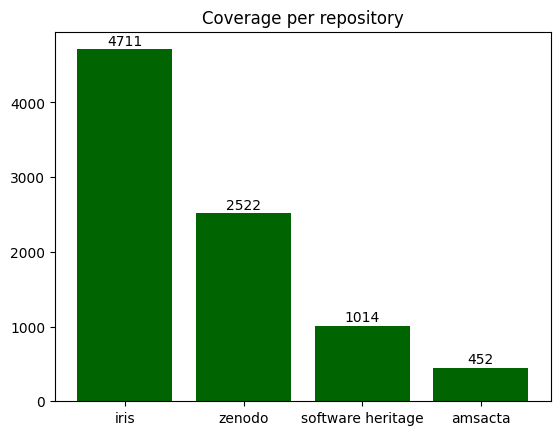

In [95]:
x = coverage.keys()
y = coverage.values()
plt.bar(x, y, color = '#006400')
plt.title('Coverage per repository')

for i, v in enumerate(y):
    plt.text(i, v + 50, str(v), ha='center')



In [55]:
coverage_cat = RQ1['iris_cat'].value_counts()
coverage_cat

iris_cat
7.12 Mostra o Esposizione                                   1996
7.04 Software                                               1986
7.05 Banche dati                                            1907
7.13 Rapporto tecnico                                       1356
7.07 Disegno                                                 387
7.03 Prodotto dell’ingegneria civile e dell’architettura     252
7.09 Performance                                             189
7.06 Composizione musicale                                   169
7.10 Manufatto                                               156
7.01 Carta tematica e geografica                             120
7.15 Test psicologici                                         87
7.02 Carta geologica                                          75
7.08 Design                                                   10
7.11 Prototipo d'arte e relativi progetti                      9
Name: count, dtype: int64

In [83]:
RQ3 = pd.read_csv('C:/Users/annan/Documents/GitHub/2024-2025/CitationsCount.csv')
df_mashup = pd.read_csv("C:/Users/annan/Downloads/mashup_v3.csv", low_memory=False)

ingoing = {'amsacta': 0, 'software heritage': 0, 'zenodo': 0, 'iris': 0}
outgoing = {'amsacta': 0, 'software heritage': 0, 'zenodo': 0, 'iris': 0}

RQ3

,doi,cite_num_outgoing,cite_num_ingoing,oci_outgoing,oci_ingoing,status
0,10.5281/zenodo.5504259,0.0,0,[],[],ok
1,10.5281/zenodo.15358180,0.0,0,[],[],ok
2,10.5281/zenodo.15249055,0.0,0,[],[],ok
3,10.5281/zenodo.15411447,0.0,0,[],[],ok
4,10.5281/zenodo.15261097,0.0,0,[],[],ok
...,...,...,...,...,...,...
3243,10.6092/unibo/amsacta/8296,0.0,0,[],[],ok
3244,10.5281/zenodo.10044574,0.0,0,[],[],ok
3245,10.5281/zenodo.7624784,0.0,0,[],[],ok
3246,10.1016/B978-0-12-809633-8.13097-3,15.0,1,"['062502328668-061603511193', '062502328668-06...",['06804331879-062502328668'],ok


In [84]:
doi_to_repo = dict(zip(df_mashup['doi'], df_mashup['src_repo']))

for index, row in RQ3.iterrows():
    doi = row['doi']
    repo = doi_to_repo[doi]
    if pd.notnull(row['cite_num_ingoing']):
        ingoing[repo] += int(row['cite_num_ingoing'])
    if pd.notnull(row['cite_num_outgoing']):
        outgoing[repo] += int(row['cite_num_outgoing'])

print("Totale citazioni in entrata:", ingoing)
print("Totale citazioni in uscita:", outgoing)


Totale citazioni in entrata: {'amsacta': 8, 'software heritage': 0, 'zenodo': 189, 'iris': 602}
Totale citazioni in uscita: {'amsacta': 0, 'software heritage': 0, 'zenodo': 196, 'iris': 1035}


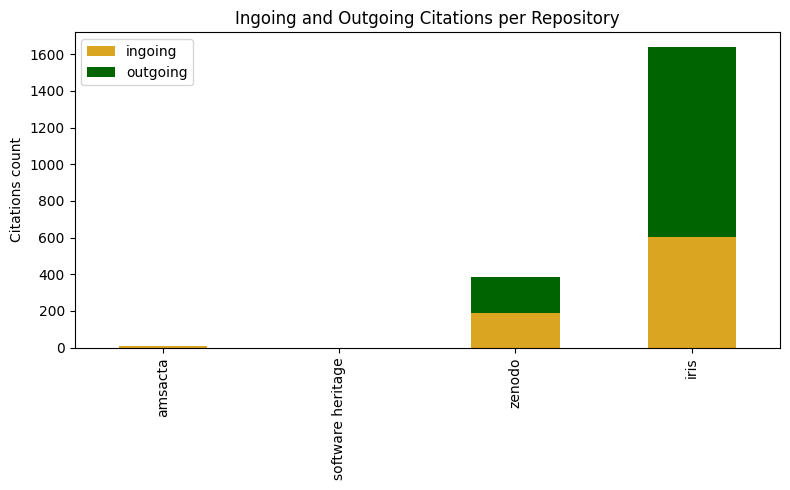

In [97]:
viz = pd.DataFrame({
    'ingoing': ingoing,
    'outgoing': outgoing})

viz.plot(kind='bar', stacked=True, figsize=(8, 5), color= ['#DAA520','#006400'])

plt.title("Ingoing and Outgoing Citations per Repository")
plt.ylabel("Citations count")
plt.tight_layout()
plt.show()